In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [0]:
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf 

In [4]:
#!pip install --user --upgrade tensorflow
tf.__version__

'2.1.0'

In [0]:
#!unzip -uq "/content/drive/My Drive/competition_data.zip" -d "/content/drive/My Drive/data"

In [0]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [6]:
# list of names all images in the given path
ids = next(os.walk("/content/drive/My Drive/data/competition_data/train/images"))[2] 
print("No. of images = ", len(ids))

No. of images =  4000


In [0]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [8]:
#Loading images and their masks and rsizing them to 128 x 128
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = tf.keras.preprocessing.image.load_img("/content/drive/My Drive/data/competition_data/train/images/"+id_, color_mode = 'grayscale')
    x_img = tf.keras.preprocessing.image.img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img("/content/drive/My Drive/data/competition_data/train/masks/"+id_, color_mode = 'grayscale'))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save and normalize images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
# Splitting the training data into train/validation data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=35)

Text(0.5, 1.0, 'Salt')

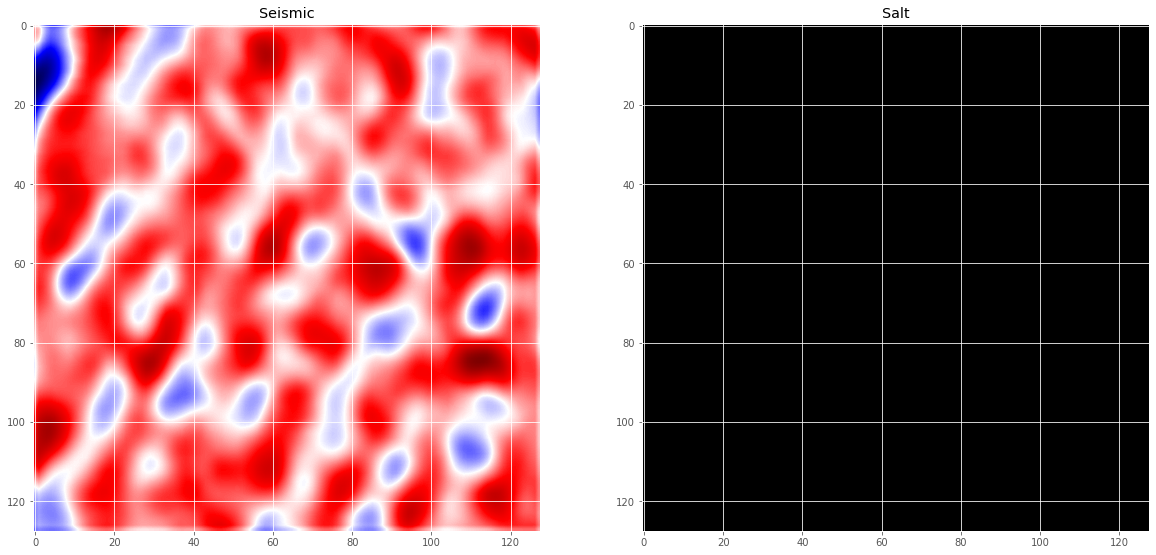

In [0]:
# Visualize any random image along with the mask
'''ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')'''

In [0]:
# Custom function to perform Convolutions on the layer
def Conv_2D(tensor_input, no_of_filters, filter_size = 3, batch_norm = True):
  # First layer of convolution
  x = tf.keras.layers.Conv2D(filters=no_of_filters, kernel_size=(filter_size, filter_size), kernel_initializer='he_normal', padding='same')(tensor_input)
  if batch_norm:
    x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  # Second layer of covolution
  x = tf.keras.layers.Conv2D(filters=no_of_filters, kernel_size=(filter_size, filter_size), kernel_initializer='he_normal', padding='same')(tensor_input)
  if batch_norm:
    x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  return x

In [0]:
# Function to call U-Net model
def get_Unet(input_img, no_filters = 16, dropout = 0.1, batchnorm = True):
  # U-Net has two parts an encoding part and a decoding part
  # First Encoding path
  c1 = Conv_2D(input_img, no_filters * 1, filter_size = 3, batch_norm = batchnorm )
  p1 = tf.keras.layers.MaxPool2D((2, 2))(c1)
  P1 = tf.keras.layers.Dropout(rate = dropout)(p1)
  
  c2 = Conv_2D(p1, no_filters * 2, filter_size = 3, batch_norm = batchnorm )
  p2 = tf.keras.layers.MaxPool2D((2, 2))(c2)
  P2 = tf.keras.layers.Dropout(rate = dropout)(p2)
  
  c3 = Conv_2D(p2, no_filters * 4, filter_size = 3, batch_norm = batchnorm )
  p3 = tf.keras.layers.MaxPool2D((2, 2))(c3)
  P3 = tf.keras.layers.Dropout(rate = dropout)(p3)
  
  c4 = Conv_2D(p3, no_filters * 8, filter_size = 3, batch_norm = batchnorm )
  p4 = tf.keras.layers.MaxPool2D((2, 2))(c4)
  p4 = tf.keras.layers.Dropout(rate = dropout)(p4)

  c5 = Conv_2D(p4, no_of_filters = no_filters * 16, filter_size = 3, batch_norm = batchnorm)
 
  # Second part of Unet i.e. Decoding
  u6 = tf.keras.layers.Conv2DTranspose(filters = no_filters * 8, kernel_size = (3, 3), strides = (2, 2) , padding ='same')(c5)
  u6 = tf.keras.layers.concatenate([u6,c4])
  u6 = tf.keras.layers.Dropout(dropout)(u6)
  c6 = Conv_2D(u6, no_of_filters = no_filters * 8, filter_size = 3, batch_norm = batchnorm)
  
  u7 = tf.keras.layers.Conv2DTranspose(filters = no_filters * 4, kernel_size = (3, 3), strides = (2, 2) , padding ='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  u7 = tf.keras.layers.Dropout(dropout)(u7)
  c7 = Conv_2D(u7, no_of_filters = no_filters * 4, filter_size = 3, batch_norm = batchnorm)

  u8 = tf.keras.layers.Conv2DTranspose(filters = no_filters * 2, kernel_size = (3, 3), strides = (2, 2) , padding ='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  u8 = tf.keras.layers.Dropout(dropout)(u8)
  c8 = Conv_2D(u8, no_of_filters = no_filters * 2, filter_size = 3, batch_norm = batchnorm)

  u9 = tf.keras.layers.Conv2DTranspose(filters = no_filters * 1, kernel_size = (3, 3), strides = (2, 2) , padding ='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1])
  u9 = tf.keras.layers.Dropout(dropout)(u9)
  c9 = Conv_2D(u9, no_of_filters = no_filters * 1, filter_size = 3, batch_norm = batchnorm)

  output = tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid')(c9)
  model = tf.keras.models.Model(inputs = [input_img], outputs = [output])
  return model

In [0]:
# Compiling the model
input_img = tf.keras.layers.Input((im_height, im_width, 1), name='img')
model = get_Unet(input_img, no_filters=16, dropout=0.1,batchnorm=True)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [0]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [15]:
# Starting the Training
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks, validation_data=(X_valid, y_valid))

Train on 3600 samples, validate on 400 samples
Epoch 1/50
3584/3600 [============================>.] - ETA: 1s - loss: 0.4341 - accuracy: 0.8103
Epoch 00001: val_loss improved from inf to 1.33088, saving model to model-tgs-salt.h5
3600/3600 [==============================] - 247s 69ms/sample - loss: 0.4332 - accuracy: 0.8108 - val_loss: 1.3309 - val_accuracy: 0.7506
Epoch 2/50
3584/3600 [============================>.] - ETA: 1s - loss: 0.3040 - accuracy: 0.8744
Epoch 00002: val_loss improved from 1.33088 to 0.56684, saving model to model-tgs-salt.h5
3600/3600 [==============================] - 244s 68ms/sample - loss: 0.3046 - accuracy: 0.8741 - val_loss: 0.5668 - val_accuracy: 0.8243
Epoch 3/50
3584/3600 [============================>.] - ETA: 1s - loss: 0.2710 - accuracy: 0.8861
Epoch 00003: val_loss improved from 0.56684 to 0.42549, saving model to model-tgs-salt.h5
3600/3600 [==============================] - 243s 67ms/sample - loss: 0.2708 - accuracy: 0.8862 - val_loss: 0.4255 - 

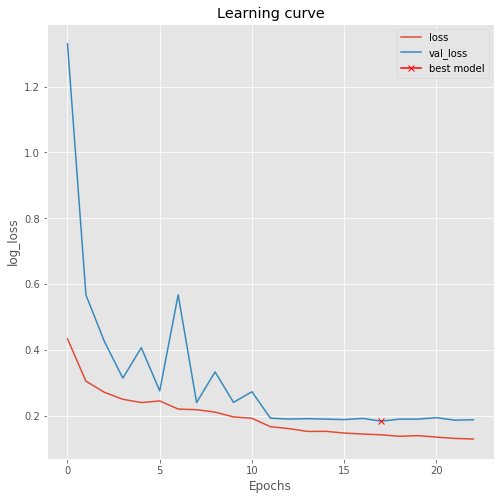

In [16]:
# Plotting the performance of model during Training
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
# Inference
model.load_weights('model-tgs-salt.h5')

In [18]:
model.evaluate(X_valid, y_valid, verbose=1)

400/400 [==============================] - 6s 15ms/sample - loss: 0.1830 - accuracy: 0.9185


[0.18304270267486572, 0.9184581]

In [19]:
# Predictions of train/val data
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

400/400 [==============================] - 6s 15ms/sample


In [0]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
# PLotting the results
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

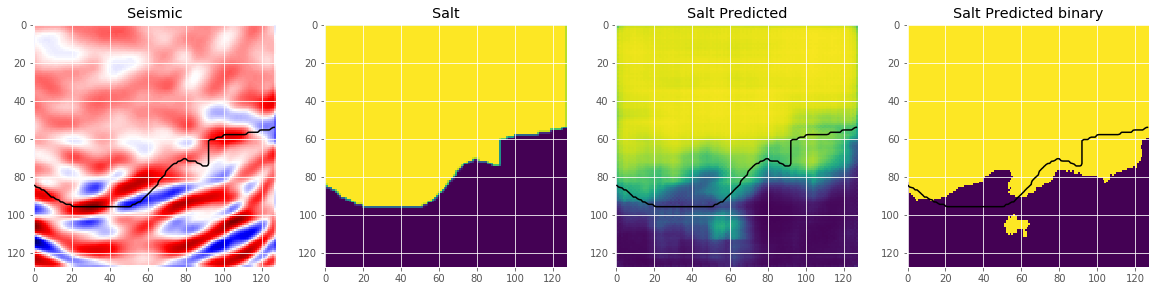

In [22]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

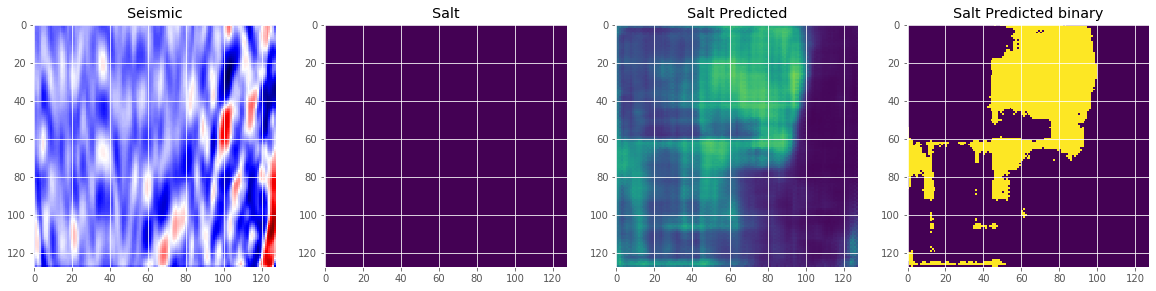

In [23]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)